In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import sklearn
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import uniform, randint

In [2]:
df=pd.read_csv('weekly_data.csv', index_col = 'week', parse_dates= True)
df.head(10)

,stringency_index,reproduction_rate,temp,humidity,precip,windspeed,new_cases,new_deaths,icu_patients,hosp_patients,case_fatality
week,,,,,,,,,,,
2020-03-30,78.70,0.141015,7.780000,67.640000,0.329800,25.920000,5208.0,731.0,6478.0,13123.0,0.140361
2020-04-06,78.70,0.128903,12.671429,63.942857,0.152714,19.157143,7773.0,976.0,9791.0,19114.0,0.125563
2020-04-13,78.70,0.137014,9.585714,64.700000,0.069429,24.142857,6871.0,948.0,8790.0,16239.0,0.137971
2020-04-20,78.70,0.165101,12.314286,55.828571,0.000000,25.985714,4847.0,794.0,7159.0,13462.0,0.163813
2020-04-27,78.70,0.240214,10.642857,79.542857,2.716429,26.528571,2527.0,581.0,5484.0,10583.0,0.229917
2020-05-04,78.70,0.202595,12.385714,67.014286,0.053571,21.585714,2018.0,386.0,4151.0,8679.0,0.191278
2020-05-11,71.30,0.173616,8.985714,64.985714,0.143286,26.242857,1354.0,240.0,2876.0,7159.0,0.177253
2020-05-18,71.30,0.109994,15.985714,69.871429,0.379000,28.257143,1304.0,142.0,1848.0,6079.0,0.108896
2020-05-25,71.30,0.118803,15.614286,64.985714,0.007286,23.314286,1100.0,134.0,1291.0,4623.0,0.121818


In [13]:
def n_week_ahead(n, real, train_size):
    
    pred = []

    for i in range(new.shape[0]):
        pred.append(new[i][n-1])

    if n == 4:
        y_test =  df[real][train_size+lag+3:]
    else:
        y_test =  df[real][train_size+lag+n-1:-4+n]
        
    r2_d1 = r2_score(y_test,pred)
    rmse_d1 =np.sqrt(mean_squared_error(y_test, pred))
    mae_d1=mean_absolute_error(y_test, pred) 
    mape_d1 =mean_absolute_percentage_error(y_test, pred) 

    print(f"week{n}_R^2 = :", round(r2_d1,3))
    print(f"week{n}_RMSE = :",round(rmse_d1,3))
    print(f"week{n}_MAE = :",round(mae_d1,3))
    print(f"week{n}_MAPE = :",round(mape_d1,3))

    forecast= pd.DataFrame({real: y_test ,
                        f'{n}_week_ahead_forecast':pred})
    
    forecast[[real,f'{n}_week_ahead_forecast']].plot(figsize=(15,5))

Forecasting Hospital Admission

In [35]:
x_series = df[:].to_numpy()
y_series = df['hosp_patients'].to_numpy()
# Set the lag and the forecast horizon h
lag = 2
h = 4
X = []
Y = []
for t in range(len(y_series)- lag - h +1):
    x= x_series[t:t+lag]
    X.append(x)
    y=y_series[t+lag:t+lag+h]
    Y.append(y)

X = np.array(X).reshape(len(X),-1)
Y = np.array(Y).reshape(-1, h)

In [38]:
Xtrain_m, Ytrain_m= X[:70], Y[:70]

# Create the parameter grid: gbm_param_grid
gbm_param_grid = {
    'eta':[0.05, 0.1, 0.2, 0.3],
    'colsample_bytree': [0.3, 0.7, 1],
    'n_estimators': [50,250,500,1000],
    'max_depth': [3, 5, 7]
}

# Instantiate the regressor: gbm
gbm = xgb.XGBRegressor()

time_split = TimeSeriesSplit(n_splits = 3, test_size=10)

# Perform grid search: grid_mse
grid_mse = GridSearchCV(param_grid = gbm_param_grid, estimator = gbm, scoring = "neg_mean_squared_error",
cv= time_split, verbose = 1)

# Fit grid_mse to the data
grid_mse.fit(Xtrain_m, Ytrain_m)

# Print the best parameters and lowest RMSE
print("Best parameters found: ", grid_mse.best_params_)
print("Lowest RMSE found: ", np.sqrt(np.abs(grid_mse.best_score_)))

Fitting 3 folds for each of 144 candidates, totalling 432 fits
Best parameters found:  {'colsample_bytree': 0.7, 'eta': 0.05, 'max_depth': 5, 'n_estimators': 50}
Lowest RMSE found:  2347.3718231958455


In [39]:
def walk_forward(X, Y, train_size):

    predictions=[]

    for i in range(X.shape[0]-train_size):
        Xtrain, Ytrain= X[i : i+train_size], Y[i : i+train_size]
        Xtest, Ytest = X[i+train_size: i+train_size+1], Y[i+train_size: i+train_size+1]
        model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=50, max_depth=5, eta=0.05, colsample_bytree = 0.7, random_state = 321)
        model.fit(Xtrain, Ytrain, verbose=0) 
        pred =model.predict(Xtest)
        predictions.append(pred)

    return predictions


In [40]:
train_size = 70
pred = walk_forward(X, Y, train_size)
new = np.array(pred).reshape(-1,4)

week1_R^2 = : 0.799
week1_RMSE = : 1588.736
week1_MAE = : 1216.088
week1_MAPE = : 0.189
week2_R^2 = : 0.714
week2_RMSE = : 1888.43
week2_MAE = : 1435.822
week2_MAPE = : 0.22
week3_R^2 = : 0.644
week3_RMSE = : 2098.015
week3_MAE = : 1631.867
week3_MAPE = : 0.251
week4_R^2 = : 0.645
week4_RMSE = : 2109.542
week4_MAE = : 1650.787
week4_MAPE = : 0.266


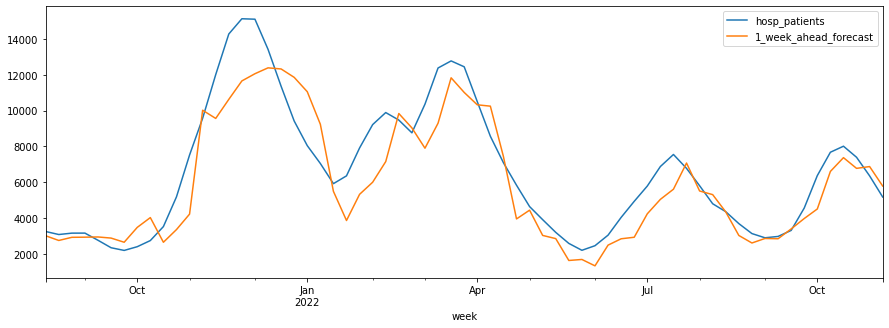

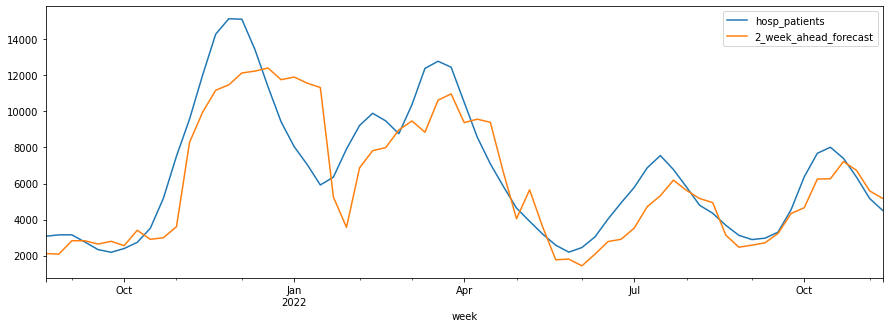

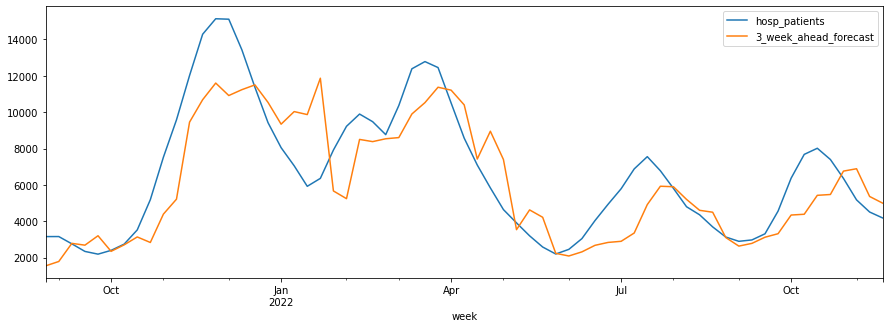

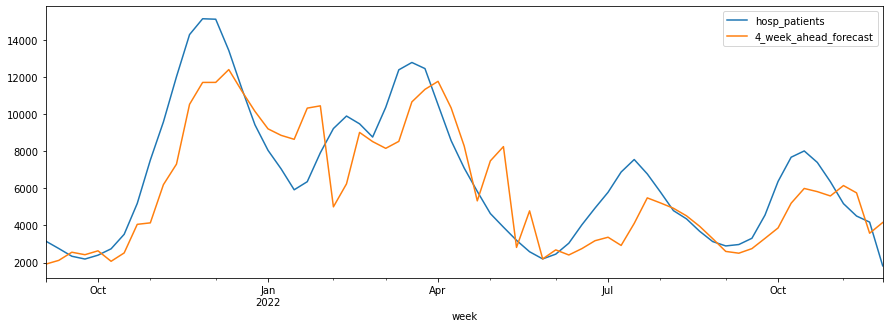

In [42]:
for i in range(1,5):
    n_week_ahead(i, real='hosp_patients', train_size= train_size)

Forecasting ICU admission

In [3]:
x_series = df[:].to_numpy()
y_series = df['icu_patients'].to_numpy()
# Set the lag and the forecast horizon h
lag = 2
h = 4
X = []
Y = []
for t in range(len(y_series)- lag - h +1):
    x= x_series[t:t+lag]
    X.append(x)
    y=y_series[t+lag:t+lag+h]
    Y.append(y)


In [4]:
X = np.array(X).reshape(len(X),-1)
Y = np.array(Y).reshape(-1, h)
X.shape
Y.shape

(135, 4)

In [7]:
Xtrain, Ytrain= X[:70], Y[:70]

# Create the parameter grid: gbm_param_grid
gbm_param_grid = {
    'eta':[0.05, 0.1, 0.2, 0.3],
    'colsample_bytree': [0.3, 0.7, 1],
    'n_estimators': [50,250,500,1000],
    'max_depth': [3,5,7]
}

# Instantiate the regressor: gbm
gbm = xgb.XGBRegressor()

time_split = TimeSeriesSplit(n_splits = 3, test_size=10)

# Perform grid search: grid_mse
grid_mse = GridSearchCV(param_grid = gbm_param_grid, estimator = gbm, scoring = "neg_mean_squared_error",
cv= time_split, verbose = 1)

# Fit grid_mse to the data
grid_mse.fit(Xtrain, Ytrain)

# Print the best parameters and lowest RMSE
print("Best parameters found: ", grid_mse.best_params_)
print("Lowest RMSE found: ", np.sqrt(np.abs(grid_mse.best_score_)))

Fitting 3 folds for each of 96 candidates, totalling 288 fits
Best parameters found:  {'colsample_bytree': 0.3, 'eta': 0.05, 'max_depth': 3, 'n_estimators': 1000}
Lowest RMSE found:  787.0373735135611


In [31]:
def walk_forward(X, Y, train_size):

    predictions=[]

    for i in range(X.shape[0]-train_size):
        Xtrain, Ytrain= X[i : i+train_size], Y[i : i+train_size]
        Xtest, Ytest = X[i+train_size: i+train_size+1], Y[i+train_size: i+train_size+1]
        model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000, max_depth=3, eta=0.05, colsample_bytree = 0.3, random_state = 321)
        model.fit(Xtrain, Ytrain, verbose=0) 
        pred =model.predict(Xtest)
        predictions.append(pred)

    return predictions


In [32]:
train_size = 70
pred = walk_forward(X, Y, train_size)

In [33]:
new = np.array(pred).reshape(-1,4)

week1_R^2 = : 0.899
week1_RMSE = : 364.021
week1_MAE = : 223.32
week1_MAPE = : 0.226
week2_R^2 = : 0.799
week2_RMSE = : 515.52
week2_MAE = : 310.544
week2_MAPE = : 0.354
week3_R^2 = : 0.774
week3_RMSE = : 548.382
week3_MAE = : 311.46
week3_MAPE = : 0.371
week4_R^2 = : 0.731
week4_RMSE = : 601.707
week4_MAE = : 339.859
week4_MAPE = : 0.499


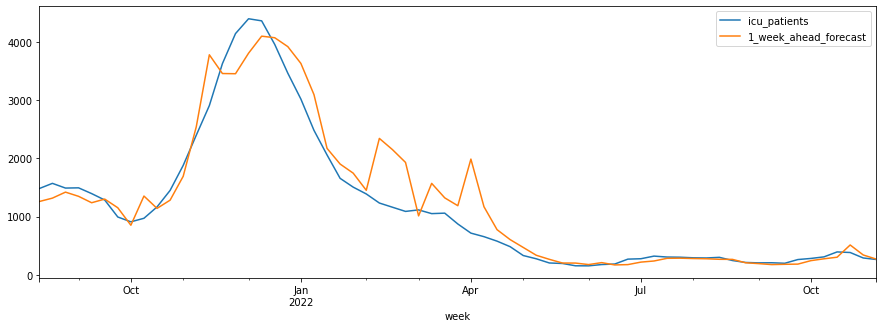

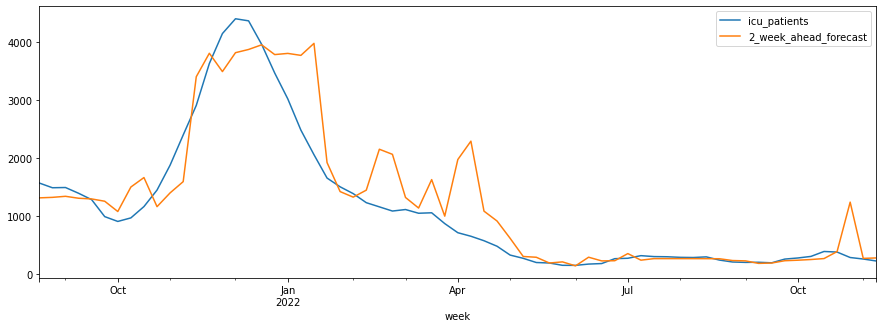

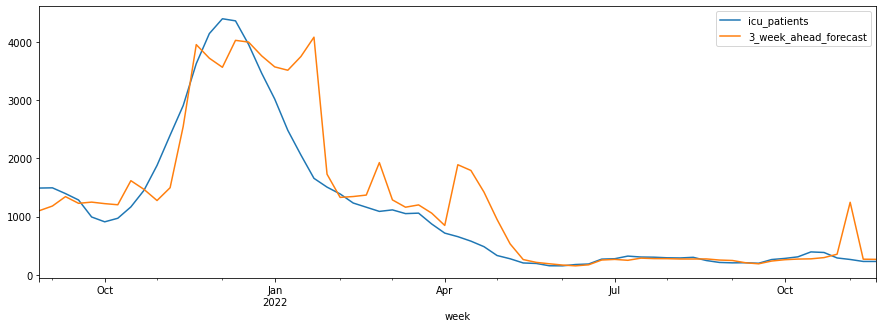

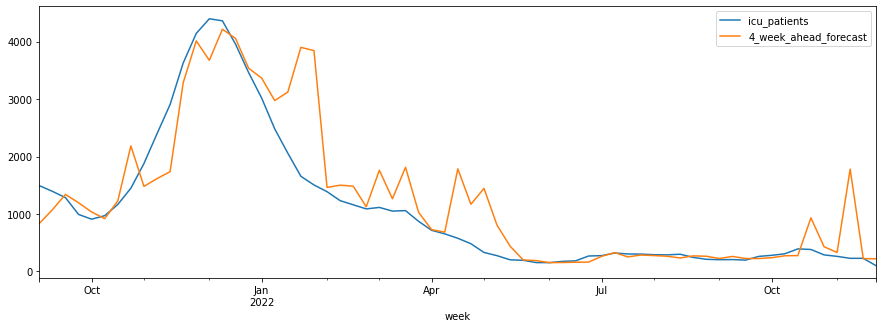

In [34]:
for i in range(1,5):
    n_week_ahead(i, real='icu_patients', train_size= train_size)

In [2]:
import session_info
session_info.show(html=False)

-----
matplotlib          3.7.1
numpy               1.22.2
pandas              1.4.1
scipy               1.10.1
session_info        1.0.0
sklearn             1.2.2
xgboost             1.7.5
-----
IPython             8.0.1
jupyter_client      7.1.2
jupyter_core        4.9.1
jupyterlab          3.2.9
notebook            6.4.8
-----
Python 3.10.2 (v3.10.2:a58ebcc701, Jan 13 2022, 14:50:16) [Clang 13.0.0 (clang-1300.0.29.30)]
macOS-12.3.1-x86_64-i386-64bit
-----
Session information updated at 2023-05-30 18:25
